In [1]:
import gwsurrogate
import numpy as np
import matplotlib.pyplot as plt
import bilby
from gwpy.timeseries import TimeSeries
from scipy.special import expit

lal.G_SI != G
lal.MSUN_SI != Msun
setting __package__ to gwsurrogate.new so relative imports work
__name__ = gwsurrogate.new.spline_evaluation
__package__= gwsurrogate.new
setting __package__ to gwsurrogate.new so relative imports work
setting __package__ to gwsurrogate.new so relative imports work


/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/gwtools/rotations.py:63: UserWarning: Could not import GWFrames, needed for rotations module
  _warnings.warn("Could not import GWFrames, needed for rotations module")
/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/gwtools/__init__.py:11: UserWarning: Could not import rotations, decompositions, or fitfuncs. These are not needed by GWSurrogate.
  _warnings.warn("Could not import rotations, decompositions, or fitfuncs. These are not needed by GWSurrogate.")


In [2]:
sur=gwsurrogate.LoadSurrogate('NRSur7dq4')

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/gwsurrogate/new/precessing_surrogate.py:245: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  self.t = h5file['t_ds'].value
/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/gwsurrogate/new/precessing_surrogate.py:272: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  'coefs': group['%s_coefs'%(key)].value,
/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/gwsurrogate/new/precessing_surrogate.py:273: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  'bfOrders': group['%s_bfOrders'%(key)].value
/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/gwsurrogate/new/precessing_surrogate.py:282: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  'coefs': group['%s_%d_coefs'%(key, i)].value,
/Users/zohaggard/anaconda2/envs/igw

Loaded NRSur7dq4 model


In [3]:
def sigmoid(time, x0, L, k):
    
    """ generate a sigmoid to be mult. to damped sinusoid.
        x is time, x0 is the midpoint of the sigmoid, L is the amplitude, and k is the growth 
    """
    
    sig = []
    
    for item in time:
        value=L/(1+np.exp(-k*(item-x0)))
        sig.append(value)
        
    return sig

In [4]:
def create_bru_values(m_odd, em, M, a, n_ref):
    
    """ 
    m_odd is odd integer, n_ref is the refractive index, which is 1/g_s (string coupling, (GR == 0)), em is 2,
    M is total mass, a is dimensionless spin, and amplitude_qnm is 
    the amplitude of the mode of interest 
    
    returns amplitude (quantum), omega_real, tau, and tp
    
    """
    
    g_s = 1/n_ref
    c = 3e8
    G = 6.67e-11
    Msun = 1.989e30
    
    conversion_w = (c**3)/(G * M * Msun)
    R_con = (2 * G * M * Msun) / (c**2)
    
    r_s = (R_con + np.sqrt((R_con**2) - 4*(a**2)))/2 #units m
    omega_real = (m_odd * np.pi /(2 * r_s * n_ref)) * c   #units 1/m --> 1/s
    omega_im = - (1/r_s) * (1/(n_ref**2)) * c
    
    tau = 1/omega_im
    tp = 1/omega_real 
    
    print("Quantum freq is {}".format(omega_real/(2*np.pi)))
    print("Quantum tau is {}".format(tau))
    print("t_s is {}".format(tp))
    
    return {'omega_real_Q': omega_real, 'omega_img_Q': omega_im,
            'tau_Q': tau, 'tp_Q': tp, 'freq_Q': (omega_real/(2*np.pi))}

In [5]:
def damped_sine(time, amplitude, tau, tp, freq, phase):
    
    """
    returns damped complex sine as h (type=array) 
    assumes that tau is negative number
    starts a time tp: anytime before is 0

    """
    
    
    h_damped = np.zeros(len(time), dtype=np.complex128)
    tidx = time >= tp
    
    damp_arg = - (time[tidx])/tau
    sin_arg = (2 * np.pi * freq * (time[tidx])) - phase
    h_damped[tidx] = amplitude*np.exp(damp_arg) * np.exp((1j*sin_arg)) 
   
    return h_damped

In [6]:
def Quantummodes_keys(time, tau, freq, tp, amplitude, phase):
    
    """ 
    model that has NR SUR (for given parameters) and associated quantum mode 
    chiA and chiB take [x,y,z] as input
    assumes dt = 1/4096
    highest l index is ellMax, assumed to be 4
    f_ref=30, and f_low=0
    
    note: NRSUR peak of waveform packet is at t=0
    
          spin=0 for now (need to change em otherwise)
    
    """
    #generate damped 
    bru_sin = damped_sine(time=time, amplitude=amplitude, tau=tau, tp=tp, freq=freq, 
                          phase=phase)
    
    sig = sigmoid(time=time, x0=tp*2, L=amplitude, k=4096)
    
    dif = len(bru_sin) - len(h)
    
    h_new = np.pad(h, (0, dif), 'constant')
    
    h_total = h_new + (bru_sin*sig/amplitude)
    
    return {'plus': h_total.real, 'cross': h_total.imag}
    

In [7]:
def Quantummodes(time, n_ref, amplitude, phase, M):
    
    """ 
    model that has NR SUR (for given parameters) and associated quantum mode 
    chiA and chiB take [x,y,x] as input
    assumes dt = 1/4096
    highest l index is ellMax, assumed to be 4
    f_ref=30, and f_low=0
    
    note: NRSUR peak of waveform packet is at t=0
    
          spin=0 for now (need to change em otherwise)
    
    """
    
    #h_new
    print(time)
    
    bru_values = create_bru_values(m_odd=1, em=0, M=M, a=0, n_ref=n_ref)
    
    bru_sin = damped_sine(time=time, amplitude=amplitude, 
                       tau=-1*bru_values['tau_Q'], tp=bru_values['tp_Q'], 
                       freq=bru_values['freq_Q'], phase=phase)
    
    sig = sigmoid(time=time, x0=bru_values['tp_Q']*2, L=amplitude, k=4096)
    
    dif = len(bru_sin) - len(h)
    
    h_new = np.pad(h, (0, dif), 'constant')
    
    h_total = h_new + (bru_sin*sig/amplitude)
    
    plt.plot(time, h_new.real, label='NRsurdq4', linestyle='--', color='blue')
    plt.plot(time, sig*bru_sin.real/amplitude, label='quantum mode', linestyle='-.', color='green')
    plt.plot(time, h_total, label='injected waveform', linestyle='-', color='orange')
    plt.legend()
    plt.xlim(-0.01,0.08)
    plt.xlabel('Time (seconds)')
    plt.ylabel('h+')
   
    
    return {'plus': h_total.real, 'cross': h_total.imag}
    

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


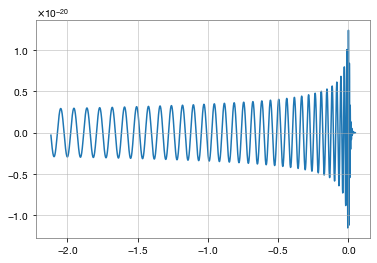

In [9]:
q = 1
chiA = [0,0,0]
chiB = [0,0,0]
M = 100
dist_mpc = 100
ellMax = 4     
inclination = 0
f_low=0
f_ref = 30
dt=1/4096

t, h, dyn = sur(q, chiA, chiB, dt=dt, f_low=f_low, ellMax=ellMax, M=M, dist_mpc=dist_mpc,
               inclination=inclination, units='mks', f_ref=f_ref)
plt.plot(t, h)

In [52]:
n_ref=3
amplitude=[6e-23, 8e-23, 1e-22, 2e-22, 4e-22, 6e-22]
duration=3

In [53]:
injection_parameters = dict(n_ref=n_ref, amplitude=amplitude, phase=0,
                            ra=0, dec=0, psi=0, geocent_time=0, M=M) #freq=63, tau=0.019, tp=0.0025)

In [54]:
injection_waveform = bilby.gw.waveform_generator.WaveformGenerator(
    time_domain_source_model=Quantummodes,
    duration=duration, sampling_frequency=4096, start_time = injection_parameters['geocent_time']+t[0])

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/bilby/gw/detector/psd.py:356: RuntimeWarning: invalid value encountered in multiply
  frequency_domain_strain = self.__power_spectral_density_interpolated(frequencies) ** 0.5 * white_noise
/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.
/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
22:02 bilby INFO    : Injected signal in H1:
22:02 bilby INFO    :   optimal SNR = 404.74
22:02 bilby INFO    :   matched filter SNR = 404.87-0.33j
22:02 bilby INFO    :   n_ref = 3
22:02 bilby INFO    :   amplitude = 2e-22
22:02 bilby INFO    :   phase = 0
22:02 bilby INFO    :   ra = 0
22:02 bilby INFO    :   dec = 0
22:0

[-2.11796114 -2.117717   -2.11747286 ...  0.88130644  0.88155058
  0.88179472]
Quantum freq is 84.79922934460372
Quantum tau is -0.00884442
t_s is 0.0018768442157077612


[{'plus': array([-4.29289971e-23+0.00000000e+00j,
         -4.56046602e-23-1.50298655e-24j,
         -4.52414984e-23+1.44042873e-24j, ...,
         -3.47337903e-26-3.07261479e-28j,
         -3.54824051e-26+9.67323369e-28j,
         -3.66190512e-26+0.00000000e+00j]),
  'cross': array([ 6.44340997e-24+0.00000000e+00j,
          4.84407947e-24-2.85564482e-24j,
          3.37413186e-24-3.17074498e-24j, ...,
         -3.52224627e-25-2.35726128e-29j,
         -3.52642122e-25+6.41687155e-28j,
         -3.53307536e-25+0.00000000e+00j])},
 {'plus': array([-4.29289971e-23+0.00000000e+00j,
         -4.56046602e-23-1.50298655e-24j,
         -4.52414984e-23+1.44042873e-24j, ...,
         -3.47337903e-26-3.07261479e-28j,
         -3.54824051e-26+9.67323369e-28j,
         -3.66190512e-26+0.00000000e+00j]),
  'cross': array([ 6.44340997e-24+0.00000000e+00j,
          4.84407947e-24-2.85564482e-24j,
          3.37413186e-24-3.17074498e-24j, ...,
         -3.52224627e-25-2.35726128e-29j,
         -3.526

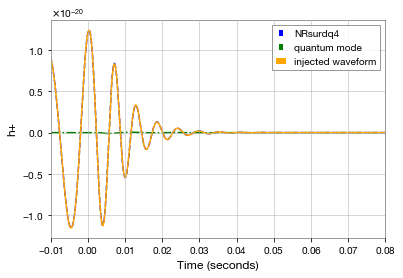

In [55]:
ifos = bilby.gw.detector.InterferometerList(['H1','L1'])
ifos.set_strain_data_from_power_spectral_densities(
    duration=duration, sampling_frequency=4096, start_time = injection_parameters['geocent_time']+t[0])
ifos.inject_signal(waveform_generator=injection_waveform,
                  parameters=injection_parameters)

In [56]:
prior = {}
prior['amplitude'] = bilby.core.prior.DeltaFunction(amplitude, r'$h_0$')
prior['tp'] = bilby.core.prior.DeltaFunction(0.001876, r'$t_{s}$')
#prior['tau'] = bilby.core.prior.DeltaFunction(0.0035034425359878212, r'$t_{s}$')
prior['tau'] = bilby.core.prior.LogUniform(1e-3, 1e-1, r'$\tau$', unit='$s$')
prior['freq'] = bilby.core.prior.Uniform(30, 100, r'frequency', unit='Hz')
prior['phase'] = bilby.core.prior.DeltaFunction(0)
prior['ra'] = bilby.core.prior.DeltaFunction(0)
prior['dec'] = bilby.core.prior.DeltaFunction(0)
prior['psi'] = bilby.core.prior.DeltaFunction(0)
prior['geocent_time'] = bilby.core.prior.DeltaFunction(0)

In [57]:
search_waveform = bilby.gw.WaveformGenerator(
    duration=duration, sampling_frequency=4096, 
    time_domain_source_model=Quantummodes_keys, start_time = injection_parameters['geocent_time']+t[0])

In [58]:
likelihood = bilby.gw.likelihood.GravitationalWaveTransient(
    interferometers=ifos, waveform_generator=search_waveform)

In [59]:
result = bilby.run_sampler(
            likelihood=likelihood, priors=prior, sampler='dynesty', npoints=100, walks=5, 
            nact=3, outdir='/Users/zohaggard/Desktop/LIGOSURF/add_quantummode/NRsurquantumfinal2', #change nref5,40
            label='Mass{}_dist{}_nref{}_Amp{}_CORRECT'.format(M, dist_mpc, n_ref, amplitude),
            resume=False, injection_parameters=dict(freq=84.799,
                                                    tau=0.0088))

22:02 bilby INFO    : Running for label 'Mass100_dist100_nref3_Amp2e-22_CORRECT', output will be saved to '/Users/zohaggard/Desktop/LIGOSURF/add_quantummode/NRsurquantumfinal2'
22:02 bilby INFO    : Using LAL version Branch: None;Tag: lal-v6.22.0;Id: 38829b72bfb5f26391b9866d286dd77db7942dd1;;Builder: Duncan Macleod <duncan.macleod@ligo.org>;Repository status: CLEAN: All modifications committed
22:02 bilby INFO    : Search parameters:
22:02 bilby INFO    :   tau = LogUniform(minimum=0.001, maximum=0.1, name='$\\tau$', latex_label='$\\tau$', unit='$s$', boundary=None)
22:02 bilby INFO    :   freq = Uniform(minimum=30, maximum=100, name='frequency', latex_label='frequency', unit='Hz', boundary=None)
22:02 bilby INFO    :   amplitude = 2e-22
22:02 bilby INFO    :   tp = 0.001876
22:02 bilby INFO    :   phase = 0
22:02 bilby INFO    :   ra = 0
22:02 bilby INFO    :   dec = 0
22:02 bilby INFO    :   psi = 0
22:02 bilby INFO    :   geocent_time = 0
/Users/zohaggard/anaconda2/envs/igwn-py37/li


0it [00:00, ?it/s]

22:03 bilby INFO    : Using sampler Dynesty with kwargs {'bound': 'multi', 'sample': 'rwalk', 'verbose': True, 'periodic': None, 'reflective': None, 'check_point_delta_t': 600, 'nlive': 100, 'first_update': None, 'walks': 5, 'npdim': None, 'rstate': None, 'queue_size': None, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': 1.5, 'bootstrap': None, 'vol_dec': 0.5, 'vol_check': 8.0, 'facc': 0.2, 'slices': 5, 'update_interval': 60, 'print_func': <bound method Dynesty._print_func of <bilby.core.sampler.dynesty.Dynesty object at 0x131db1e50>>, 'dlogz': 0.1, 'maxiter': None, 'maxcall': None, 'logl_max': inf, 'add_live': True, 'print_progress': True, 'save_bounds': False, 'n_effective': None, 'maxmcmc': 5000, 'nact': 3}
22:03 bilby INFO    : Checkpoint every n_check_point = 20000
22:03 bilby INFO    : Using dynesty version 1.0.1
22:03 bilby INFO    : Using the bilby-implemented rwalk sample metho


1it [00:04,  4.16s/it, bound:0 nc:1 ncall:101 eff:1.0% logz-ratio=196033.89+/-0.33 dlogz:inf>0.10]
4it [00:04,  2.92s/it, bound:0 nc:1 ncall:104 eff:3.8% logz-ratio=196042.84+/-0.30 dlogz:49.136>0.10]
7it [00:04,  2.06s/it, bound:0 nc:1 ncall:107 eff:6.5% logz-ratio=196048.15+/-0.31 dlogz:44.582>0.10]
10it [00:04,  1.45s/it, bound:0 nc:1 ncall:110 eff:9.1% logz-ratio=196057.62+/-0.32 dlogz:35.648>0.10]
13it [00:04,  1.03s/it, bound:0 nc:1 ncall:113 eff:11.5% logz-ratio=196060.27+/-0.27 dlogz:30.164>0.10]
16it [00:04,  1.36it/s, bound:0 nc:2 ncall:117 eff:13.7% logz-ratio=196061.67+/-0.25 dlogz:28.745>0.10]
19it [00:04,  1.89it/s, bound:0 nc:1 ncall:120 eff:15.8% logz-ratio=196063.61+/-0.26 dlogz:26.710>0.10]
22it [00:05,  2.62it/s, bound:0 nc:1 ncall:123 eff:17.9% logz-ratio=196067.84+/-0.32 dlogz:25.247>0.10]
25it [00:05,  3.52it/s, bound:0 nc:2 ncall:127 eff:19.7% logz-ratio=196070.00+/-0.27 dlogz:20.316>0.10]
28it [00:05,  4.60it/s, bound:0 nc:1 ncall:131 eff:21.4% logz-ratio=19607

248it [00:47,  1.08it/s, bound:0 nc:31 ncall:1215 eff:20.4% logz-ratio=196088.31+/-0.13 dlogz:0.397>0.10]
249it [00:48,  1.08it/s, bound:0 nc:25 ncall:1240 eff:20.1% logz-ratio=196088.31+/-0.13 dlogz:0.392>0.10]
250it [00:49,  1.27it/s, bound:0 nc:12 ncall:1252 eff:20.0% logz-ratio=196088.31+/-0.13 dlogz:0.388>0.10]
251it [00:49,  1.48it/s, bound:0 nc:11 ncall:1263 eff:19.9% logz-ratio=196088.32+/-0.13 dlogz:0.384>0.10]
252it [00:49,  1.73it/s, bound:0 nc:9 ncall:1272 eff:19.8% logz-ratio=196088.32+/-0.13 dlogz:0.380>0.10] 
254it [00:50,  2.07it/s, bound:0 nc:13 ncall:1286 eff:19.8% logz-ratio=196088.33+/-0.13 dlogz:0.371>0.10]
255it [00:50,  2.68it/s, bound:0 nc:3 ncall:1289 eff:19.8% logz-ratio=196088.33+/-0.13 dlogz:0.367>0.10] 
256it [00:51,  1.82it/s, bound:0 nc:25 ncall:1314 eff:19.5% logz-ratio=196088.33+/-0.13 dlogz:0.363>0.10]
257it [00:52,  1.37it/s, bound:0 nc:30 ncall:1344 eff:19.1% logz-ratio=196088.34+/-0.13 dlogz:0.359>0.10]
258it [00:53,  1.51it/s, bound:0 nc:13 ncall:1

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.



359it [02:18,  1.09it/s, bound:1 nc:15 ncall:3607 eff:10.0% logz-ratio=196088.53+/-0.12 dlogz:0.121>0.10]
360it [02:18,  1.28it/s, bound:1 nc:11 ncall:3618 eff:10.0% logz-ratio=196088.53+/-0.12 dlogz:0.120>0.10]
361it [02:19,  1.38it/s, bound:1 nc:15 ncall:3633 eff:9.9% logz-ratio=196088.53+/-0.12 dlogz:0.119>0.10] 
362it [02:20,  1.38it/s, bound:1 nc:18 ncall:3651 eff:9.9% logz-ratio=196088.53+/-0.12 dlogz:0.118>0.10]
363it [02:20,  1.52it/s, bound:1 nc:12 ncall:3663 eff:9.9% logz-ratio=196088.53+/-0.12 dlogz:0.116>0.10]

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.



364it [02:21,  1.64it/s, bound:2 nc:12 ncall:3675 eff:9.9% logz-ratio=196088.53+/-0.12 dlogz:0.116>0.10]
365it [02:21,  1.59it/s, bound:2 nc:17 ncall:3692 eff:9.9% logz-ratio=196088.54+/-0.12 dlogz:0.115>0.10]
366it [02:22,  1.63it/s, bound:2 nc:14 ncall:3706 eff:9.9% logz-ratio=196088.54+/-0.12 dlogz:0.113>0.10]
367it [02:23,  1.58it/s, bound:2 nc:17 ncall:3723 eff:9.9% logz-ratio=196088.54+/-0.12 dlogz:0.112>0.10]

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.



368it [02:23,  1.54it/s, bound:3 nc:17 ncall:3740 eff:9.8% logz-ratio=196088.54+/-0.12 dlogz:0.111>0.10]
369it [02:24,  1.45it/s, bound:3 nc:20 ncall:3760 eff:9.8% logz-ratio=196088.54+/-0.12 dlogz:0.110>0.10]
370it [02:25,  1.61it/s, bound:3 nc:11 ncall:3771 eff:9.8% logz-ratio=196088.54+/-0.12 dlogz:0.109>0.10]
371it [02:25,  1.72it/s, bound:3 nc:12 ncall:3783 eff:9.8% logz-ratio=196088.54+/-0.12 dlogz:0.108>0.10]

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.



372it [02:26,  1.81it/s, bound:4 nc:11 ncall:3794 eff:9.8% logz-ratio=196088.54+/-0.12 dlogz:0.107>0.10]
373it [02:26,  1.75it/s, bound:4 nc:15 ncall:3809 eff:9.8% logz-ratio=196088.54+/-0.12 dlogz:0.105>0.10]
374it [02:27,  1.83it/s, bound:4 nc:10 ncall:3819 eff:9.8% logz-ratio=196088.54+/-0.12 dlogz:0.104>0.10]
375it [02:27,  1.73it/s, bound:4 nc:14 ncall:3833 eff:9.8% logz-ratio=196088.55+/-0.12 dlogz:0.103>0.10]
376it [02:28,  1.52it/s, bound:4 nc:19 ncall:3852 eff:9.8% logz-ratio=196088.55+/-0.12 dlogz:0.102>0.10]

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.



377it [02:29,  1.42it/s, bound:5 nc:18 ncall:3870 eff:9.7% logz-ratio=196088.55+/-0.12 dlogz:0.101>0.10]
378it [02:30,  1.45it/s, bound:5 nc:15 ncall:3885 eff:9.7% logz-ratio=196088.55+/-0.12 dlogz:0.100>0.10]

22:05 bilby INFO    : Writing checkpoint file /Users/zohaggard/Desktop/LIGOSURF/add_quantummode/NRsurquantumfinal2/Mass100_dist100_nref3_Amp2e-22_CORRECT_resume.pickle



378it [02:30,  2.51it/s, bound:5 nc:1 ncall:3885 eff:12.3% logz-ratio=196088.64+/-0.11 dlogz:0.001>0.10]

22:05 bilby INFO    : Sampling time: 0:02:26.022587
22:05 bilby INFO    : Summary of results:
nsamples: 478
log_noise_evidence: -208024.559
log_evidence: -11935.920 +/-  0.111
log_bayes_factor: 196088.639 +/-  0.111



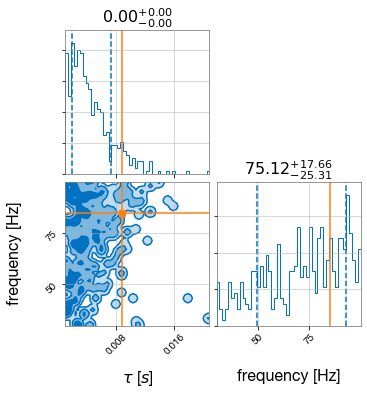

In [60]:
result.plot_corner()